In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind, ttest_rel
import pingouin as pg
import warnings

In [2]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
warnings.filterwarnings('ignore', category=RuntimeWarning)
#pd.options.display.float_format = lambda x: f"{x:.2e}" 모든 데이터프레임 소수 표기법 변경

In [3]:
# 챌린저 매치 로그
challenger = pd.read_csv("match_details_challenger_20241226_1609.csv")

In [4]:
# 그랜드마스터 매치 로그
grandmaster = pd.read_csv("match_details_grandmaster_20241223_1403.csv")

In [5]:
# 매치 로그 합치기
df_concat = pd.concat([challenger, grandmaster], ignore_index=True)

In [6]:
print( "전처리 전 데이터 크기:", len(df_concat))
print( "전처리 전 매치 데이터 수:", int(len(df_concat)/8))

전처리 전 데이터 크기: 68552
전처리 전 매치 데이터 수: 8569


In [7]:
# 중복 제거
df = df_concat.drop_duplicates()

In [8]:
# 1. 총합비용이 0인 행 제거
df = df[df['총합비용'] != 0]

# 2. 매치ID별로 순위가 1~8 모두 없는 매치ID에 해당하는 행 제거
valid_match_ids = df[df['순위'].isin([1, 2, 3, 4, 5, 6, 7, 8])]['매치ID'].unique()
df = df[df['매치ID'].isin(valid_match_ids)]

In [9]:
print( "전처리 후 데이터 크기:", len(df))
print( "전처리 후 매치 데이터 수:", int(len(df)/8))

전처리 후 데이터 크기: 64720
전처리 후 매치 데이터 수: 8090


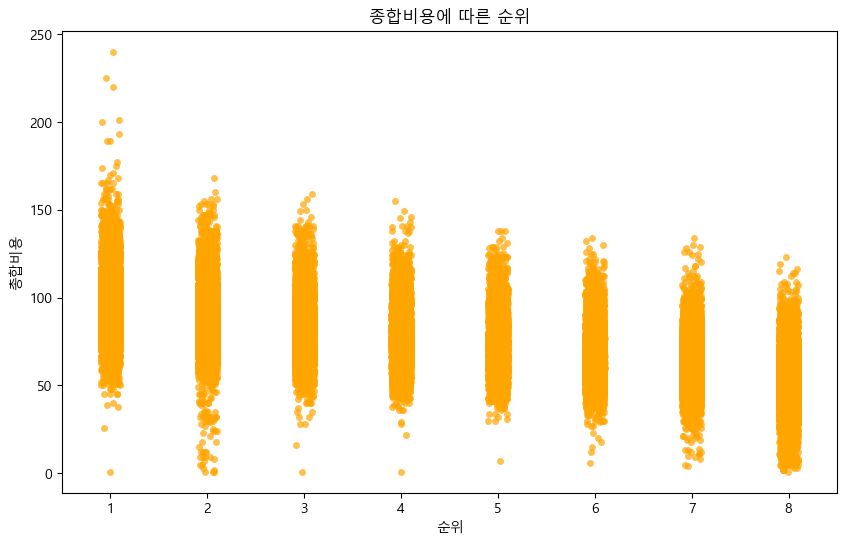

In [10]:
# 1. 종합비용에 따른 순위
plt.figure(figsize=(10, 6))
sns.stripplot(x='순위', y='총합비용', data=df, jitter=True, alpha=0.7, color="orange")
plt.title("종합비용에 따른 순위")
plt.xlabel("순위")
plt.ylabel("총합비용")
plt.show()

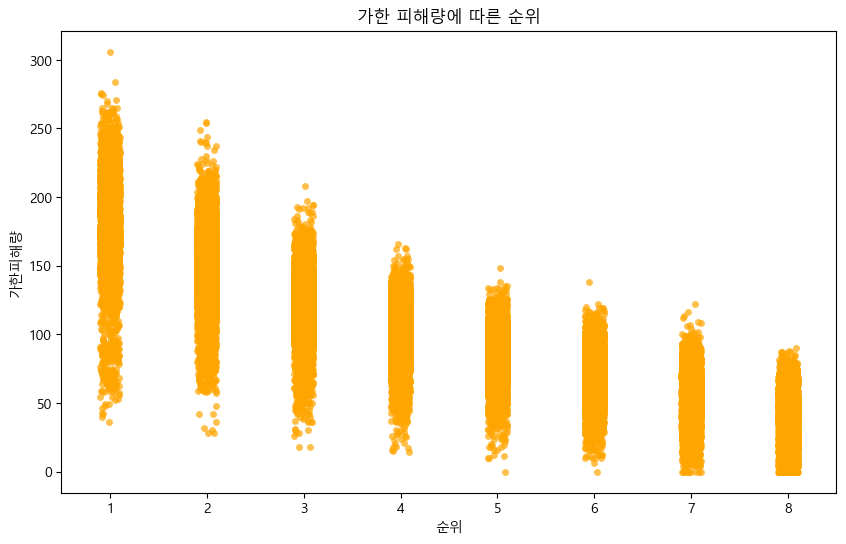

In [11]:
# 2. 가한 피해량에 따른 순위
plt.figure(figsize=(10, 6))
sns.stripplot(x='순위', y='가한피해량', data=df, jitter=True, alpha=0.7, color="orange")
plt.title('가한 피해량에 따른 순위')
plt.xlabel('순위')
plt.ylabel('가한피해량')
plt.show()

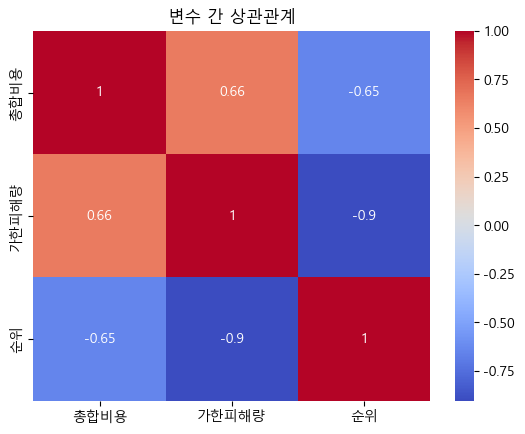

In [12]:
# 3. 변수 간 상관관계
corr = df[['총합비용', '가한피해량', '순위']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('변수 간 상관관계')
plt.show()

In [13]:
# 4. 덱 타입에 따른 평균 순위
avg_rank_by_deck_type = df.groupby('덱타입')['순위'].mean()
print("덱 타입에 따른 평균 순위:")
print(avg_rank_by_deck_type)

덱 타입에 따른 평균 순위:
덱타입
리롤    4.211740
운영    4.646595
Name: 순위, dtype: float64


In [14]:
# 5. 파열 or 파쇄 아이템 여부에 따른 평균 순위
avg_rank_by_condition = df.groupby('파열or파쇄')['순위'].mean()
print("\n파열 or 파쇄 아이템 여부에 따른 평균 순위:")
print(avg_rank_by_condition)


파열 or 파쇄 아이템 여부에 따른 평균 순위:
파열or파쇄
False    4.889438
True     4.286718
Name: 순위, dtype: float64


In [15]:
# 6. 상처 아이템 여부에 따른 평균 순위
avg_rank_by_condition = df.groupby('상처')['순위'].mean()
print("\n상처 아이템 여부에 따른 평균 순위:")
print(avg_rank_by_condition)


상처 아이템 여부에 따른 평균 순위:
상처
False    4.749799
True     4.267457
Name: 순위, dtype: float64


In [16]:
# 7. 상위 등수에서 주로 사용된 유닛
top_units = df[df['순위'] <= 4]['사용한유닛'].str.extractall(r"([a-zA-Z]+)\(")[0].value_counts()
print("\n상위 등수에서 주로 사용된 유닛:")
print(top_units.head(5))


상위 등수에서 주로 사용된 유닛:
0
Rumble    10901
Illaoi    10846
Irelia     9271
Rell       8704
elise      8456
Name: count, dtype: int64


In [17]:
# 1. 종합비용과 순위 간의 상관분석
corr_cost_rank, p_cost_rank = pearsonr(df['총합비용'], df['순위'])

In [18]:
print("종합비용-순위 상관계수:",round(corr_cost_rank, 4))
if p_cost_rank < 0.0001:
    print("종합비용-순위 p-value: {:.2e}".format(p_cost_rank))
else:
    print("종합비용-순위 p-value:", round(p_cost_rank, 4))

종합비용-순위 상관계수: -0.6479
종합비용-순위 p-value: 0.00e+00


In [19]:
# 1번에 대한 Kruskal-Wallis 검정
kruskal_results_cost = pg.kruskal(dv='순위', between='총합비용', data=df)
kruskal_results_cost = kruskal_results_cost.rename(columns={
    'Source': '독립변수',
    'ddof1': '자유도',
    'H': 'H-통계량',
    'p-unc': 'p-value'
})
kruskal_results_cost['p-value'] = kruskal_results_cost['p-value'].apply(lambda x: f"{x:.2e}")
kruskal_results_cost

,독립변수,자유도,H-통계량,p-value
Kruskal,총합비용,174,29605.753006,0.00e+00


In [20]:
# 1-1. 종합비용과 순위 t검정(1등과 2등에 대해서만 비교)
df_onetwo = df[df["순위"].isin([1, 2])]
cost_rank1 = df_onetwo[df_onetwo['순위'] == 1]['총합비용']
cost_rank2 = df_onetwo[df_onetwo['순위'] == 2]['총합비용']

cost_ttest_stat, dmg_ttest_p = ttest_ind(cost_rank1, cost_rank2, equal_var=False)

In [21]:
print("종합비용-순위 t-통계량(1등과 2등):",round(cost_ttest_stat, 4))
if p_cost_rank < 0.0001:
    print("종합비용-순위 p-value: {:.2e}".format(dmg_ttest_p))
else:
    print("종합비용-순위 p-value:", round(dmg_ttest_p, 4))

종합비용-순위 t-통계량(1등과 2등): 24.7029
종합비용-순위 p-value: 2.84e-132


In [22]:
# 2. 가한 피해량과 순위 간의 상관분석
corr_damage_rank, p_damage_rank = pearsonr(df['가한피해량'], df['순위'])

In [23]:
print("가한피해량-순위 상관계수:",round(corr_damage_rank, 4))
if p_damage_rank < 0.0001:
    print("가한피해량-순위 p-value: {:.2e}".format(p_damage_rank))
else:
    print("가한피해량-순위 p-value:", round(p_damage_rank, 4))

가한피해량-순위 상관계수: -0.9031
가한피해량-순위 p-value: 0.00e+00


In [24]:
# 2번에 대한 Kruskal-Wallis 검정
kruskal_results_dmg = pg.kruskal(dv='순위', between='가한피해량', data=df)
kruskal_results_dmg = kruskal_results_dmg.rename(columns={
    'Source': '독립변수',
    'ddof1': '자유도',
    'H': 'H-통계량',
    'p-unc': 'p-value'
})

kruskal_results_dmg['p-value'] = kruskal_results_dmg['p-value'].apply(lambda x: f"{x:.2e}")

kruskal_results_dmg

,독립변수,자유도,H-통계량,p-value
Kruskal,가한피해량,271,54973.93673,0.00e+00


In [25]:
# 2-1. 가한 피해량과 순위 t검정(1등과 2등에 대해서만 비교)
damage_rank1 = df_onetwo[df_onetwo['순위'] == 1]['가한피해량']
damage_rank2 = df_onetwo[df_onetwo['순위'] == 2]['가한피해량']

dmg_ttest_stat, dmg_ttest_p = ttest_ind(damage_rank1, damage_rank2, equal_var=False)

In [26]:
print("가한피해량-순위 t-통계량(1등과 2등):",round(dmg_ttest_stat, 4))
if p_damage_rank < 0.0001:
    print("가한피해량-순위 p-value: {:.2e}".format(dmg_ttest_p))
else:
    print("가한피해량-순위 p-value:", round(dmg_ttest_p, 4))

가한피해량-순위 t-통계량(1등과 2등): 76.3434
가한피해량-순위 p-value: 0.00e+00


In [27]:
# 3. 덱 타입에 따른 평균 순위 차이 (t-검정)
reroll_rank = df[df['덱타입'] == '리롤']['순위']
operation_rank = df[df['덱타입'] == '운영']['순위']
t_deck, p_deck = ttest_ind(reroll_rank, operation_rank, equal_var=False)

In [28]:
print("덱 타입 평균 순위 t-통계량:",round(t_deck, 6))
if p_deck < 0.0001:
    print("덱 타입 평균 순위 p-value: {:.2e}".format(p_deck))
else:
    print("덱 타입 평균 순위 p-value:", round(p_deck, 4))

덱 타입 평균 순위 t-통계량: -23.138571
덱 타입 평균 순위 p-value: 9.22e-118


In [29]:
# 4. 파열 or 파쇄 아이템 여부에 따른 평균 순위 차이 (t-검정)
condition_true = df[df['파열or파쇄'] == True]['순위']
condition_false = df[df['파열or파쇄'] == False]['순위']
t_condition, p_condition = ttest_ind(condition_true, condition_false, equal_var=False)

In [30]:
print("파열/파쇄 아이템 여부 평균 순위 t-통계량:",round(t_condition, 6))
if p_condition < 0.0001:
    print("파열/파쇄 아이템 여부 평균 순위 p-value: {:.2e}".format(p_condition))
else:
    print("파열/파쇄 아이템 여부 평균 순위 p-value:", round(p_condition, 4))

파열/파쇄 아이템 여부 평균 순위 t-통계량: -31.859884
파열/파쇄 아이템 여부 평균 순위 p-value: 2.60e-220


In [31]:
# 5. 상처 아이템 여부에 따른 평균 순위 차이 (t-검정)
wound_true = df[df['상처'] == True]['순위']
wound_false = df[df['상처'] == False]['순위']
t_wound, p_wound = ttest_ind(wound_true, wound_false, equal_var=False)

In [32]:
print("상처 아이템 여부 평균 순위 t-통계량:",round(t_condition, 6))
if p_condition < 0.0001:
    print("상처 아이템 여부 평균 순위 p-value: {:.2e}".format(p_condition))
else:
    print("상처 아이템 여부 평균 순위 p-value:", round(p_condition, 4))

상처 아이템 여부 평균 순위 t-통계량: -31.859884
상처 아이템 여부 평균 순위 p-value: 2.60e-220


In [33]:
# 순위별 종합비용 이상치 탐지 및 사용된 유닛 비교
def detect_outliers_high_cost_by_rank(df, rank_col, cost_col, unit_col):
    results = {}
    
    # 대상 순위: 5~8등
    target_ranks = [5, 6, 7, 8]
    for rank in target_ranks:
        rank_df = df[df[rank_col] == rank]  # 해당 순위의 데이터 추출
        
        # IQR 계산
        q1 = rank_df[cost_col].quantile(0.25)
        q3 = rank_df[cost_col].quantile(0.75)
        iqr = q3 - q1
        outlier_threshold_high = q3 + 1.5 * iqr
        outlier_threshold_low = q1 - 1.5 * iqr

        # 평균 계산
        rank_cost_mean = rank_df[cost_col].mean()

        # 이상치 중 평균보다 높은 값만 추출
        outlier_df = rank_df[(rank_df[cost_col] > outlier_threshold_high) & (rank_df[cost_col] > rank_cost_mean)]

        # 사용된 유닛 추출
        outlier_units = outlier_df[unit_col].str.extractall(r"([a-zA-Z]+)\(")[0].value_counts()

        # 결과 저장
        results[rank] = {
            "이상치 개수": len(outlier_df),
            "이상치 사용 유닛 (Top 5)": outlier_units.head(5)
        }

    return results

In [34]:
def summarize_results_by_rank(results):
    total_outliers = 0
    combined_outlier_units = {}

    for result in results.values():
        # 개수 합산
        total_outliers += result["이상치 개수"]

        # 유닛 사용 횟수 합산
        for unit, count in result["이상치 사용 유닛 (Top 5)"].items():
            combined_outlier_units[unit] = combined_outlier_units.get(unit, 0) + count

    # Top 5 정렬
    sorted_outlier_units = sorted(combined_outlier_units.items(), key=lambda x: x[1], reverse=True)[:5]

    # 결과 반환
    return {
        "총 이상치 개수": total_outliers,
        "이상치 사용 유닛 (Top 5)": sorted_outlier_units
    }

In [35]:
# 이상치 제거 전 원본 데이터 사용
results_high_cost_by_rank = detect_outliers_high_cost_by_rank(df, rank_col="순위", cost_col="총합비용", unit_col="사용한유닛")

In [36]:
# 종합 결과 함수 호출 및 출력
summarized_results = summarize_results_by_rank(results_high_cost_by_rank)

In [37]:
# 결과 출력
for rank, result in results_high_cost_by_rank.items():
    print(f"\n{rank}등:")
    print(f"이상치 개수: {result['이상치 개수']}")
    print("이상치 사용 유닛 (Top 5):")
    for unit, count in result["이상치 사용 유닛 (Top 5)"].items():
        print(f"{unit}: {count}")


5등:
이상치 개수: 137
이상치 사용 유닛 (Top 5):
KogMaw: 75
Blitzcrank: 71
Amumu: 68
Garen: 60
FlyGuy: 50

6등:
이상치 개수: 188
이상치 사용 유닛 (Top 5):
KogMaw: 87
Amumu: 86
Blitzcrank: 85
Garen: 65
Nocturne: 62

7등:
이상치 개수: 140
이상치 사용 유닛 (Top 5):
KogMaw: 64
Blitzcrank: 64
Amumu: 62
Garen: 50
FlyGuy: 45

8등:
이상치 개수: 85
이상치 사용 유닛 (Top 5):
KogMaw: 41
Blitzcrank: 37
Amumu: 35
Garen: 31
Nocturne: 27


In [38]:
# 종합 결과 출력
print(f"총 이상치 개수: {summarized_results['총 이상치 개수']}")
print("이상치 사용 유닛 (Top 5):")
for unit, count in summarized_results["이상치 사용 유닛 (Top 5)"]:
    print(f"{unit}: {count}")

총 이상치 개수: 550
이상치 사용 유닛 (Top 5):
KogMaw: 267
Blitzcrank: 257
Amumu: 251
Garen: 206
FlyGuy: 95


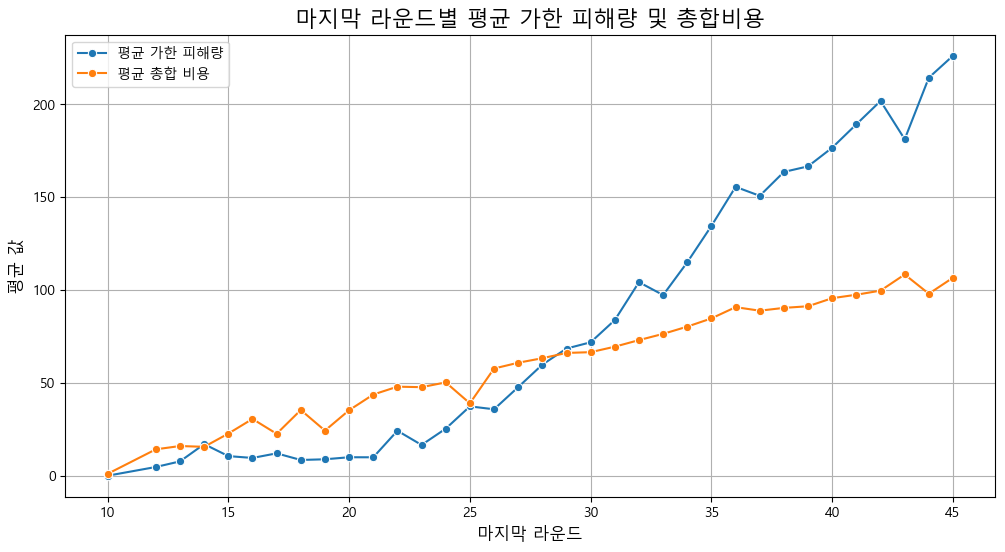

In [39]:
# 마지막 라운드로 그룹화
grouped_data = df.groupby('마지막 라운드').agg({
    '가한피해량': 'mean',
    '총합비용': 'mean',
    '유저명': 'count'
}).rename(columns={'유저명': '플레이어수'}).reset_index()

# 시각화
plt.figure(figsize=(12, 6))

# 피해량 비교
sns.lineplot(data=grouped_data, x='마지막 라운드', y='가한피해량', label='평균 가한 피해량', marker='o')

# 비용 비교
sns.lineplot(data=grouped_data, x='마지막 라운드', y='총합비용', label='평균 총합 비용', marker='o')

# 그래프 꾸미기
plt.title('마지막 라운드별 평균 가한 피해량 및 총합비용', fontsize=16)
plt.xlabel('마지막 라운드', fontsize=12)
plt.ylabel('평균 값', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# 최종 라운드가 같은 플레이어끼리 비교
# 동일한 매치ID와 마지막 라운드로 그룹화
grouped = df.groupby(['매치ID', '마지막 라운드'])

In [41]:
# Prepare lists to compare higher-ranked vs lower-ranked players for damage dealt and total cost
higher_rank_damage = []
lower_rank_damage = []
higher_rank_cost = []
lower_rank_cost = []

In [42]:
for match_id, group in df.groupby('매치ID'):
    for i, row in group.iterrows():
        similar_round = group[(group['마지막 라운드'] >= row['마지막 라운드'] - 1) & 
                              (group['마지막 라운드'] <= row['마지막 라운드'] + 1)]
        
        if len(similar_round) > 1:
            similar_round = similar_round.sort_values('순위')
            higher_rank_damage.append(similar_round.iloc[0]['가한피해량'])
            lower_rank_damage.append(similar_round.iloc[1]['가한피해량']) 
            higher_rank_cost.append(similar_round.iloc[0]['총합비용'])
            lower_rank_cost.append(similar_round.iloc[1]['총합비용']) 

In [43]:
# 가한 피해량과 총합 비용에 대한 paired t-test 수행
damage_ttest = ttest_rel(higher_rank_damage, lower_rank_damage)
cost_ttest = ttest_rel(higher_rank_cost, lower_rank_cost)

In [44]:
# 가한 피해량 T-검정 결과 출력
print("가한 피해량 평균 차이 t-통계량:", round(damage_ttest.statistic, 6))
if damage_ttest.pvalue < 0.0001:
    print("가한 피해량 평균 차이 p-value: {:.2e}".format(damage_ttest.pvalue))
else:
    print("가한 피해량 평균 차이 p-value:", round(damage_ttest.pvalue, 4))

가한 피해량 평균 차이 t-통계량: 162.068788
가한 피해량 평균 차이 p-value: 0.00e+00


In [45]:
# 총합 비용 T-검정 결과 출력
print("총합 비용 평균 차이 t-통계량:", round(cost_ttest.statistic, 6))
if cost_ttest.pvalue < 0.0001:
    print("총합 비용 평균 차이 p-value: {:.2e}".format(cost_ttest.pvalue))
else:
    print("총합 비용 평균 차이 p-value:", round(cost_ttest.pvalue, 4))

총합 비용 평균 차이 t-통계량: 43.032833
총합 비용 평균 차이 p-value: 0.00e+00
